In [222]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

print(f' ------------- \n',
      f'Versions: \n',
      f'------------- \n'
      f' numpy=={np.__version__} \n'
     )

 ------------- 
 Versions: 
 ------------- 
 numpy==1.22.1 



## Reference Values

In [223]:
h_ref = 1e-2
rho_ref = 5e3
lambda_ref = 2.5e3**2*rho_ref
c_ref = np.sqrt(lambda_ref/rho_ref)

## Material Properties

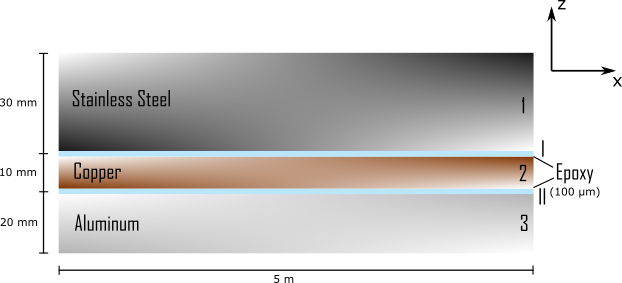

- ### Layer 1 (Aluminum):

In [224]:
rho_1 = 2700/rho_ref
vp_1 = 6320/c_ref
vs_1 = 3130/c_ref
mu_1 = vs_1**2*rho_1
lambda_1 = vp_1**2*rho_1-2*mu_1
h_1 = 2e-2/h_ref

- ### Layer 2 (Copper):

In [225]:
rho_2 = 8930/rho_ref
vp_2 = 4660/c_ref
vs_2 = 2660/c_ref
mu_2 = vs_2**2*rho_2
lambda_2 = vp_2**2*rho_2-2*mu_2
h_2 = 1e-2/h_ref

- ### Layer 3 (Stainless Steel):

In [226]:
rho_3 = 7900/rho_ref
vp_3 = 5790/c_ref
vs_3 = 3100/c_ref
mu_3 = vs_3**2*rho_3
lambda_3 = vp_3**2*rho_3-2*mu_3
h_3 = 3e-2/h_ref

- ### Interfaces:

> ##### Interface II (Layers 1-2)

In [227]:
h_interface_2 = 100e-6/h_ref
vp_interface_2 = 2150/c_ref
vs_interface_2 = 1030/c_ref
rho_interface_2 = 1200/rho_ref

> ##### Interface III (Layers 2-3)

In [228]:
h_interface_3 = 100e-6/h_ref
vp_interface_3 = 2150/c_ref
vs_interface_3 = 1030/c_ref
rho_interface_3 = 1200/rho_ref

> ##### Computing specular stiffness (QSA):

In [229]:
def computeSpecularStiffness(thickness, rho, P_speed, S_speed):
    mu = (S_speed**2)*rho
    lamb = (P_speed**2)*rho-2*mu
    s = 1/mu
    c = 2*mu+lamb
    K_specular = np.linalg.inv(thickness*np.array([[s, 0, 0], [0, s, 0], [0, 0, 1/c]]))
    return K_specular

> ##### Generating Defects:

In [230]:
def computeDefectiveK(K_specular, defect_location, magnitude):
    defect_dict = {'xx': 0, 'yy': 1, 'zz': 2}
    K_defective = K_specular
    loc = defect_dict[defect_location]
    K_defective[loc, loc] = (1-magnitude)*K_defective[loc, loc]
    return K_defective

- ### Computing acoustic tensors:

In [231]:
def computePropagationMatrices(kx, kp, kt, h_up, h_down):
    
    kp_z = np.sqrt(kp**2-kx**2, dtype=complex)
    kt_z = np.sqrt(kt**2-kx**2, dtype=complex)
    
    gamma_up = np.zeros((3, 3), dtype=complex)
    np.fill_diagonal(
        gamma_up,
        [np.exp(1j*kp_z*h_up),
         np.exp(1j*kt_z*h_up),
         np.exp(1j*kt_z*h_up)]
    )
    gamma_down = np.zeros((3, 3), dtype=complex)
    np.fill_diagonal(
        gamma_down,
        [np.exp(-1j*kp_z*h_down),
         np.exp(-1j*kt_z*h_down),
         np.exp(-1j*kt_z*h_down)]
    )

    A_up = np.array(
        [[kx/kp, -kt_z/kt, 0],
         [0, 0, 1],
         [kp_z/kp, kx/kt, 0]]
    )
    A_down = np.array(
        [[kx/kp, kt_z/kt, 0],
         [0, 0, 1],
         [-kp_z/kp, kx/kt, 0]]
    )

    M_up = np.dot(np.dot(A_up, gamma_up), np.linalg.inv(A_up))
    M_down = np.dot(np.dot(A_down, gamma_down), np.linalg.inv(A_down))

    return M_up, M_down


########################################################################################


def computeImpedances(omega, kx, kp, kt, lambda_, mu):

    kp_z = np.sqrt(kp**2-kx**2, dtype=complex)
    kt_z = np.sqrt(kt**2-kx**2, dtype=complex)

    A_aux_up = np.array([[kx, kp_z], [kt_z, -kx]], dtype=complex)
    A_aux_down = np.array([[-kx, kp_z], [kt_z, kx]], dtype=complex)

    C1_up = np.array(
        [[-2*mu*kp_z*kx/omega], [(mu/omega)*(kx**2-kt_z**2)]],
        dtype = complex
    )
    C2_up = np.array(
        [[-(lambda_*kp**2+2*mu*kp_z**2)/omega], [2*mu*kt_z*kx/omega]],
        dtype=complex
    )
    C1_down = np.array(
        [[-2*mu*kp_z*kx/omega], [-(mu/omega)*(kx**2-kt_z**2)]],
        dtype=complex
    )
    C2_down = np.array(
        [[(lambda_*kp**2+2*mu*kp_z**2)/omega], [2*mu*kt_z*kx/omega]],
        dtype=complex
    )

    z_11_up_z_13_up = np.dot(np.linalg.inv(A_aux_up), C1_up)
    z_11_up = z_11_up_z_13_up[0]
    z_13_up = z_11_up_z_13_up[1]
    z_12_up = 0
    z_21_up = 0
    z_22_up = -mu*kt_z/omega
    z_23_up = 0
    z_32_up = 0
    z_31_up_z_33_up = np.dot(np.linalg.inv(A_aux_up), C2_up)
    z_31_up = z_31_up_z_33_up[0]
    z_33_up = z_31_up_z_33_up[1]

    z_11_down_z_13_down = np.dot(np.linalg.inv(A_aux_down), C1_down)
    z_11_down = z_11_down_z_13_down[0]
    z_13_down = z_11_down_z_13_down[1]
    z_12_down = 0
    z_21_down = 0
    z_22_down = mu*kt_z/omega
    z_23_down = 0
    z_32_down = 0
    z_31_down_z_33_down = np.dot(np.linalg.inv(A_aux_down), C2_down)
    z_31_down = z_31_down_z_33_down[0]
    z_33_down = z_31_down_z_33_down[1]

    Z_up = np.array(
        [[z_11_up, z_12_up, z_13_up],
         [z_21_up, z_22_up, z_23_up],
         [z_31_up, z_32_up, z_33_up]],
        dtype=complex
    )

    Z_down = np.array(
        [[z_11_down, z_12_down, z_13_down],
         [z_21_down, z_22_down, z_23_down],
         [z_31_down, z_32_down, z_33_down]],
        dtype=complex
    )

    return Z_up, Z_down

## Computing the mode total displacement field ($u_T$) at the top of the plate

In [232]:
def computeModeStructure(
    vp,
    vs,
    rho,
    thickness,
    K_interfaces,
    kx,
    freq,
    tol=1e-1
):
    n_layers = len(layers_vp)
    w = freq*2*np.pi*h_ref/c_ref
    # G = 0 due to the material being in vacuum:
    G = np.zeros((3, 3))
    n_interface = 0
    for layer in range(n_layers):
        h = thickness[layer]
        mu = (vs[layer]**2)*rho[layer]
        lambda_ = (vp[layer]**2)*rho[layer]-2*mu
        kp = w/vp[layer]
        kt = w/vs[layer]
        theta1 = np.arcsin(complex(kx/kp, -0.0))
        theta2 = np.arcsin(complex(kx/kt, -0.0))
        theta3 = theta2
        theta4 = theta1
        theta5 = theta2
        theta6 = theta1
        kz1 = kp*np.cos(theta1)
        kz2 = kt*np.cos(theta2, dtype=complex)
        kz3 = kt*np.cos(theta3, dtype=complex)
        kz4 = kp*np.cos(theta4, dtype=complex)
        kz5 = kt*np.cos(theta5, dtype=complex)
        kz6 = kt*np.cos(theta6, dtype=complex)
        sn4 = np.sin(theta4, dtype=complex)
        sn5 = np.sin(theta5, dtype=complex)
        cn4 = np.cos(theta4, dtype=complex)
        cn5 = np.cos(theta5, dtype=complex)
        M1, M2 = computePropagationMatrices(kx, kp, kt, h, -h)
        Z1, Z2 = computeImpedances(w, kx, kp, kt, lambda_, mu)
        R =  np.dot(np.linalg.inv(G - Z1), (Z2 - G))
        P = np.dot(np.dot(M1, R), M2)
        G = np.dot((np.dot(Z1, P) + Z2), np.linalg.inv(P + np.eye(3)))
        if layer < (n_layers-1):
            Ginf = np.dot(
                np.linalg.inv(np.eye(3)-1j*w*np.dot(
                    G,
                    np.linalg.inv(K_interfaces[n_interface])
                )),
                G
            )
            G = Ginf
            n_interface += 1
    # Verifying if its a mode point:
    G_det = np.abs(np.linalg.det(G))
    if G_det < tol:
        _, s, vh = np.linalg.svd(G)
        mode_displacement = vh[:][2]
        mode_eigenvalue = s[2]
        return G_det, mode_displacement, mode_eigenvalue
    else:
        print ('This is not a Lamb mode, please choose other parameters values')

- ##### Chosen mode:
\
This mode was chosen using the dispersion curves analysis developed in compute_dispersion_curves

In [233]:
interface_of_interest = 'copper-stainless steel'
direction_of_interest = 'xx'

In [234]:
def load_mode_parameters():
    with open(f'./results/modes_parameters/kx_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        kx = pickle.load(fp)
    with open(f'./results/modes_parameters/freq_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        freq = 1000*pickle.load(fp)
        
    return kx, freq

In [235]:
kx, freq = load_mode_parameters()

print(f' kx = {kx} \n',
      f'freq = {freq/1000} kHz')

 kx = 0.03199999999999993 
 freq = 165.83800000000394 kHz


- ##### Invariant Embedding:

In [236]:
layers_vp = [vp_1, vp_2, vp_3]
layers_vs = [vs_1, vs_2, vs_3]
layers_rho = [rho_1, rho_2, rho_3]
layers_thickness = [h_1, h_2, h_3]
K_specular_2 = computeSpecularStiffness(
    h_interface_2,
    rho_interface_2,
    vp_interface_2,
    vs_interface_2
)
K_specular_3 = computeSpecularStiffness(
    h_interface_3,
    rho_interface_3,
    vp_interface_3,
    vs_interface_3
)
K_interfaces = [K_specular_2, K_specular_3]

G_det, u_total, mode_eigenvalue = computeModeStructure(
    layers_vp,
    layers_vs,
    layers_rho,
    layers_thickness,
    K_interfaces,
    kx,
    freq,
    tol=1e-1
)

C:\Users\berna\AppData\Local\Temp\ipykernel_26848\1158131242.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_up = np.array(
C:\Users\berna\AppData\Local\Temp\ipykernel_26848\1158131242.py:97: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_down = np.array(


In [237]:
print(f' mode eigenvalue = {mode_eigenvalue} \n',
      f'det(G) = {G_det} \n', 
      f'Total Displacement Field = {u_total}')

 mode eigenvalue = 6.888260147194723e-07 
 det(G) = 1.5523802422647286e-08 
 Total Displacement Field = [ 9.99920514e-01+0.j          0.00000000e+00+0.j
 -8.43355943e-19-0.01260816j]


> PS: The mode eigenvalue and the determinant of the superficial impedance tensor (G) should be values close to 0

## Computing the specular downgoing displacement field ($u_2$) at the top of the plate

In [238]:
def computeU2(
    vp,
    vs,
    rho,
    thickness,
    K_interfaces,
    kx,
    freq,
    u_total
):
    n_layers = len(layers_vp)
    w = freq*2*np.pi*h_ref/c_ref
    # Ginf = 0 due to the material being in vacuum:
    Ginf = np.zeros((3, 3))
    n_interface = 0
    R_list = []
    P_list = []
    G_list = []
    for layer in range(n_layers):
        h = thickness[layer]
        mu = (vs[layer]**2)*rho[layer]
        lambda_ = (vp[layer]**2)*rho[layer]-2*mu
        kp = w/vp[layer]
        kt = w/vs[layer]
        theta1 = np.arcsin(complex(kx/kp, -0.0))
        theta2 = np.arcsin(complex(kx/kt, -0.0))
        theta3 = theta2
        theta4 = theta1
        theta5 = theta2
        theta6 = theta1
        kz1 = kp*np.cos(theta1)
        kz2 = kt*np.cos(theta2, dtype=complex)
        kz3 = kt*np.cos(theta3, dtype=complex)
        kz4 = kp*np.cos(theta4, dtype=complex)
        kz5 = kt*np.cos(theta5, dtype=complex)
        kz6 = kt*np.cos(theta6, dtype=complex)
        sn4 = np.sin(theta4, dtype=complex)
        sn5 = np.sin(theta5, dtype=complex)
        cn4 = np.cos(theta4, dtype=complex)
        cn5 = np.cos(theta5, dtype=complex)
        M1, M2 = computePropagationMatrices(kx, kp, kt, h, -h)
        Z1, Z2 = computeImpedances(w, kx, kp, kt, lambda_, mu)
        R =  np.dot(np.linalg.inv(Ginf - Z1), (Z2 - Ginf))
        P = np.dot(np.dot(M1, R), M2)
        G = np.dot((np.dot(Z1, P) + Z2), np.linalg.inv(P + np.eye(3)))
        if layer < (n_layers-1):
            Ginf = np.dot(
                np.linalg.inv(np.eye(3)-1j*w*np.dot(
                    G,
                    np.linalg.inv(K_interfaces[n_interface])
                )),
                G
            )
            n_interface += 1
        R_list.append(R)
    u2 = np.dot(np.linalg.inv(P+np.eye(3,3)), u_total)
    return u2, R_list

In [239]:
u2, R_list = computeU2(
    layers_vp,
    layers_vs,
    layers_rho,
    layers_thickness,
    K_interfaces,
    kx,
    freq,
    u_total
)

C:\Users\berna\AppData\Local\Temp\ipykernel_26848\1158131242.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_up = np.array(
C:\Users\berna\AppData\Local\Temp\ipykernel_26848\1158131242.py:97: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_down = np.array(


In [240]:
print(f'Specular Downgoing Field = {u2}')

Specular Downgoing Field = [0.49996026+0.00154115j 0.        +0.j         0.06542512-0.00630408j]


## Propagating the mode and computing $\Delta u^{Specular}$ across the interface of interest

> PS: Notice that now we are sweeping the structure from top to bottom

- #### Discretizing $u_2$ in relation to x: 

$\bf{u_2}$(x) = $u_2 . e^{i.k_x.x}$ \
$\bf{\bar{u}_2}$($k_x$) = FFT($\bf{u_2}$(x))

C:\Users\berna\AppData\Local\Temp\ipykernel_26848\1158131242.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_up = np.array(
C:\Users\berna\AppData\Local\Temp\ipykernel_26848\1158131242.py:97: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_down = np.array(


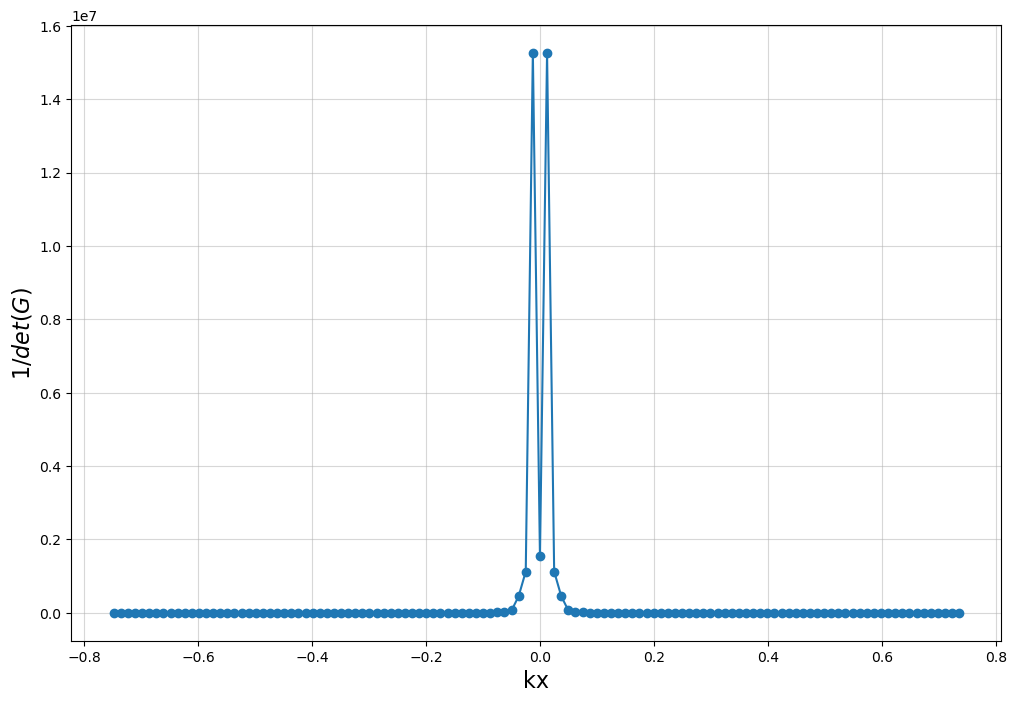

In [260]:
G_det_list = []

x = np.arange(0, 5, 0.042)
x_dimensionless = x/h_ref
nx = len(x)
dx = x_dimensionless[1] - x_dimensionless[0]
kx_max = 1/(2*dx)
dkx = kx_max/(nx/2)
kx_plus = np.arange(0, kx_max, dkx)
kx_minus = np.arange(-kx_max, 0, dkx)
kx_vec = np.append(kx_minus, kx_plus)*2*np.pi
nkx = len(kx_vec)

for ii in range(nkx):

    G_det, tt, ee = computeModeStructure(
        layers_vp,
        layers_vs,
        layers_rho,
        layers_thickness,
        K_interfaces,
        kx_vec[ii],
        freq,
        tol=2000000
    )
    G_det_list.append(1/G_det)

plt.figure(figsize=(12, 8))
plt.plot(kx_vec, G_det_list, 'o-')
plt.ylabel('$1/det(G)$', size=16)
plt.xlabel('kx', size=16)
plt.grid(alpha=0.5)
plt.show()

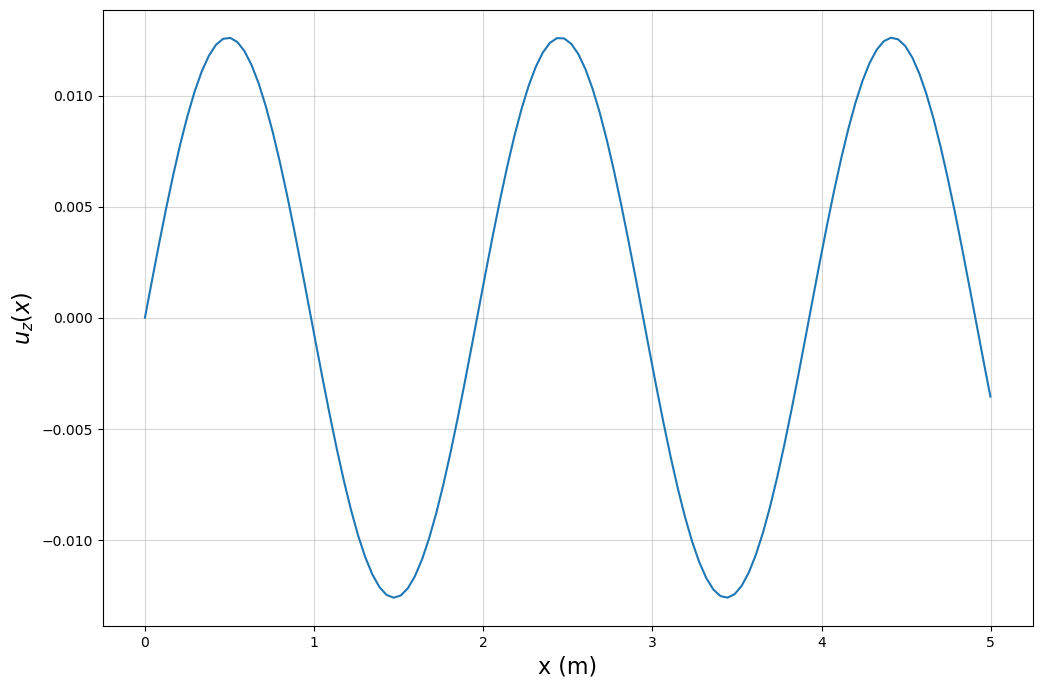

In [244]:
u_2 = np.array([u2 * np.exp(1j*kx*x_dimensionless[ii]) for ii in range(nx)]).T
u_t = np.array([u_total * np.exp(1j*kx*x_dimensionless[ii]) for ii in range(nx)]).T
u_1 = u_t - u_2

plt.figure(figsize=(12, 8))
plt.plot(x, u_t[2])
plt.ylabel('$u_z (x)$', size=16)
plt.xlabel('x (m)', size=16)
plt.grid(alpha=0.5)
plt.show()

- #### Computing $\Delta^{Spec} (x)$:

In [245]:
def computeInterfaceDelta(
    interface_of_interest,
    vp,
    vs,
    rho,
    thickness,
    K_interfaces,
    kx,
    freq,
    u2,
    R_list
):
    n_layers = len(layers_vp)
    w = freq*2*np.pi*h_ref/c_ref
    interfaces_dict = {
        'aluminum-copper': 0,
        'copper-stainless steel': 1
    }
    interface = interfaces_dict[interface_of_interest]
    n_interface = 1
    nx = u2.shape[1]
    u_bar = np.array([np.fft.fftshift(np.fft.fft(u2[dim, :])) for dim in range(u2.shape[0])])
    delta_u_bar = []
    for xj in range(nx):
        n_interface = 1
        u2_top = u_bar[:, xj]
        Gsup = np.zeros((3, 3))
        for layer in range(n_layers-1, -1, -1):
            h = thickness[layer]
            mu = (vs[layer]**2)*rho[layer]
            lambda_ = (vp[layer]**2)*rho[layer]-2*mu
            kp = w/vp[layer]
            kt = w/vs[layer]
            theta1 = np.arcsin(complex(kx/kp, -0.0))
            theta2 = np.arcsin(complex(kx/kt, -0.0))
            theta3 = theta2
            theta4 = theta1
            theta5 = theta2
            theta6 = theta1
            kz1 = kp*np.cos(theta1)
            kz2 = kt*np.cos(theta2, dtype=complex)
            kz3 = kt*np.cos(theta3, dtype=complex)
            kz4 = kp*np.cos(theta4, dtype=complex)
            kz5 = kt*np.cos(theta5, dtype=complex)
            kz6 = kt*np.cos(theta6, dtype=complex)
            sn4 = np.sin(theta4, dtype=complex)
            sn5 = np.sin(theta5, dtype=complex)
            cn4 = np.cos(theta4, dtype=complex)
            cn5 = np.cos(theta5, dtype=complex)
            M1, M2 = computePropagationMatrices(kx, kp, kt, h, -h)
            Z1, Z2 = computeImpedances(w, kx, kp, kt, lambda_, mu)
            if layer < (n_layers-1):
                u2_top = np.dot(np.linalg.inv(Z2), t_bottom)/(-1j*w)
            R = R_list[layer]
            u2_bottom = np.dot(M2, u2_top)
            u1_bottom = np.dot(R, u2_bottom)
            ut_bottom = u1_bottom+u2_bottom
            t_bottom = -1j*w*(np.dot(Z1, u1_bottom)+np.dot(Z2, u2_bottom))
            ut_top = ut_bottom-np.dot(np.linalg.inv(K_interfaces[n_interface]), t_bottom)
            if interface == n_interface:
                delta_u_bar.append(ut_bottom - ut_top)
            n_interface -= 1
    delta_u_bar = np.array(delta_u_bar).T
    delta_u = np.array([np.fft.ifft(np.fft.ifftshift(delta_u_bar[dim, :])) for dim in range(delta_u_bar.shape[0])])
    return delta_u

In [246]:
delta_u = computeInterfaceDelta(
    interface_of_interest,
    layers_vp,
    layers_vs,
    layers_rho,
    layers_thickness,
    K_interfaces,
    kx,
    freq,
    u_2,
    R_list
)

C:\Users\berna\AppData\Local\Temp\ipykernel_26848\1158131242.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_up = np.array(
C:\Users\berna\AppData\Local\Temp\ipykernel_26848\1158131242.py:97: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_down = np.array(


- #### Plotting $\Delta^{Spec} (x)$ components:

> PS: Notice that since there is no displacement in $y$-direction (SH waves), $\Delta^{Spec}_y (x) = 0$

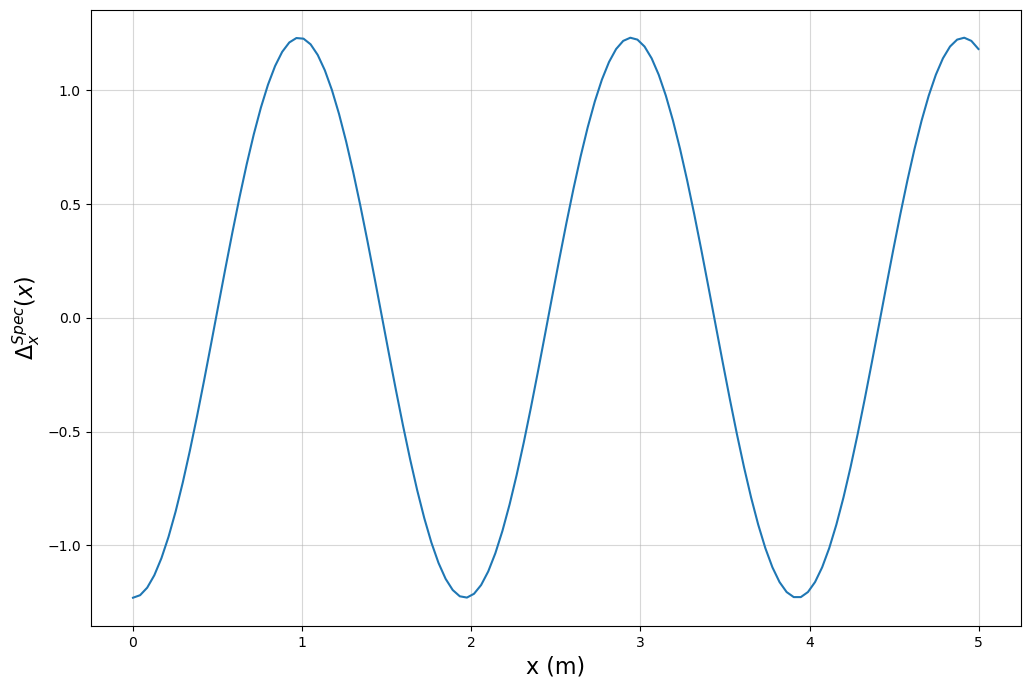

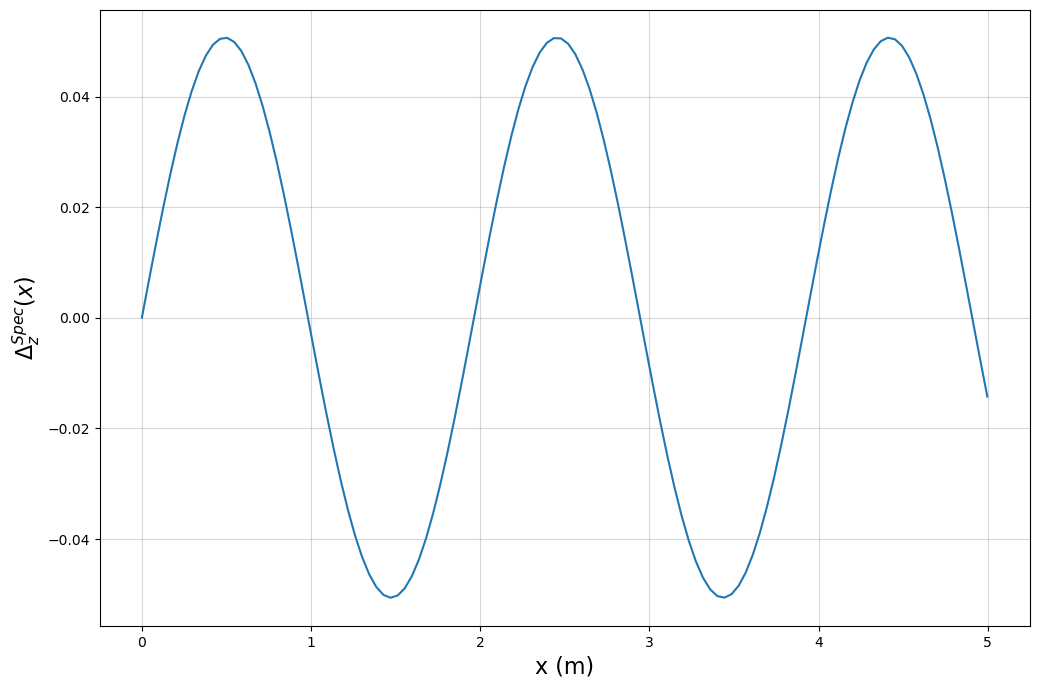

In [247]:
plt.figure(figsize=(12, 8))
plt.plot(x, delta_u[0])
plt.ylabel('$\Delta^{Spec}_x (x)$', size=16)
plt.xlabel('x (m)', size=16)
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(x, delta_u[2])
plt.ylabel('$\Delta^{Spec}_z (x)$', size=16)
plt.xlabel('x (m)', size=16)
plt.grid(alpha=0.5)
plt.show()

- #### Saving $\Delta^{Spec} (x)$ and the specular field $\bf{u}^{Spec}$:

In [261]:
def saveDeltaU():
    with open(f'./results/modes_parameters/deltaU_{interface_of_interest}_{direction_of_interest}', 'wb') as fp:
        pickle.dump(delta_u, fp)
        
def saveSpecularField():
    with open(f'./results/modes_parameters/u_1_spec_{interface_of_interest}_{direction_of_interest}', 'wb') as fp:
        pickle.dump(u_1, fp)
    with open(f'./results/modes_parameters/u_2_spec_{interface_of_interest}_{direction_of_interest}', 'wb') as fp:
        pickle.dump(u_2, fp)
    with open(f'./results/modes_parameters/x_{interface_of_interest}_{direction_of_interest}', 'wb') as fp:
        pickle.dump(x, fp)
    with open(f'./results/modes_parameters/kx_vec_{interface_of_interest}_{direction_of_interest}', 'wb') as fp:
        pickle.dump(kx_vec, fp)

In [262]:
saveDeltaU()
saveSpecularField()